In [1]:
#引入库
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus']=False

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.rcParams['font.sans-serif']=['simhei']
plt.rcParams['font.serif'] = ['simhei']

import warnings
warnings.filterwarnings('ignore')
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'C:\Windows\Fonts\SimHei.ttf',size=12)
sns.set(font=myfont.get_name())

In [2]:
#数据读取
df = pd.read_csv('stu_portrait.csv')

In [3]:
#数据处理：缺失值检查,false即表示无缺失值,若对行处理则令axis=1
print(df.isnull().any())

personid           False
score              False
time_before_ddl    False
post_views         False
job_num            False
consume_time       False
dtype: bool


In [4]:
#数据处理：去除重复值,使用drop_duplicates函数，输出为重复值数
df.duplicated().sum()

0

In [5]:
#基于pyspark的数据统计分析，此处仅使用描述分析与频率统计
#mean()函数或describe()函数对均值进行描述统计.T表示矩阵逆置，行输出
df.describe().T

,count,mean,std,min,25%,50%,75%,max
personid,223.0000,133158421.5919,23175770.3844,111943588.0000,111946751.0000,147373617.0000,147390514.5000,197263536.0000
score,223.0000,46.9957,23.4939,0.0300,35.8300,50.2100,57.9400,92.7200
time_before_ddl,223.0000,13.9161,24.4386,0.1100,2.6650,4.9600,13.6300,114.8700
post_views,223.0000,9.4484,4.6398,0.0000,6.0000,10.0000,11.0000,20.0000
job_num,223.0000,10.7444,12.2022,0.0000,1.0000,5.0000,21.5000,44.0000
consume_time,223.0000,16.0709,14.5094,0.0400,5.2600,12.7300,23.7800,67.6400


In [6]:
#rename，更改列名以方便可视化展现
df.rename(columns={'personid':'学生编号','score':'分数','post_views':'帖子浏览次数','job_num':'完成作业次数',
                   'time_before_ddl':'提前提交作业时间','consume_time':'完成作业耗时'},inplace=True)
df

,学生编号,分数,提前提交作业时间,帖子浏览次数,完成作业次数,完成作业耗时
0,111943588,59.9300,10.0200,11,2,24.4900
1,111943630,81.3400,0.7300,17,0,64.2100
2,111943631,46.6800,18.2300,12,0,2.7700
3,111943800,59.9000,4.0000,11,0,30.7000
4,111943864,74.8100,0.5300,16,0,33.0200
...,...,...,...,...,...,...
218,197259586,88.8800,108.8300,5,29,4.4200
219,197259971,90.8600,114.8700,7,29,4.8400
220,197261324,90.1600,77.0400,7,29,38.9700
221,197261517,92.2100,109.1000,8,29,38.0100


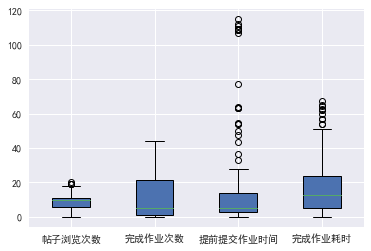

In [7]:
d1 = df['帖子浏览次数']
d2 = df['完成作业次数']
d3 = df['提前提交作业时间']
d4 = df['完成作业耗时']

# 横坐标，显示均值
plt.boxplot([d1,d2,d3,d4],patch_artist=True,labels=['帖子浏览次数','完成作业次数','提前提交作业时间','完成作业耗时'])
plt.show()

In [8]:
# 箱型图判断异常点
def box_outlier(data):
    df = data.copy(deep=True)
    out_index = []
    for col in df.columns:             # 对每一列分别用箱型图进行判断
        Q1 = df[col].quantile(q=0.25)       # 下四分位
        Q3 = df[col].quantile(q=0.75)       # 上四分位
        low_whisker = Q1 - 1.5 * (Q3 - Q1)  # 下边缘
        up_whisker = Q3 + 1.5 * (Q3 - Q1)   # 上边缘
        
        # 寻找异常点,获得异常点索引值，删除索引值所在行数据
        rule = (df[col] > up_whisker) | (df[col] < low_whisker)  
        out = df[col].index[rule]
        out_index += out.tolist()  
    df.drop(out_index, inplace=True)
    return df

df_clean = box_outlier(df)
df_clean

,学生编号,分数,提前提交作业时间,帖子浏览次数,完成作业次数,完成作业耗时
0,111943588,59.9300,10.0200,11,2,24.4900
2,111943631,46.6800,18.2300,12,0,2.7700
3,111943800,59.9000,4.0000,11,0,30.7000
4,111943864,74.8100,0.5300,16,0,33.0200
5,111943930,58.1900,3.8800,10,1,14.5800
...,...,...,...,...,...,...
205,147393731,51.4900,0.1100,11,29,3.4100
206,147393768,52.8900,4.8800,10,44,34.0000
207,147393863,24.8200,1.7200,5,44,5.4000
208,153867160,54.9700,3.1000,11,44,17.7500


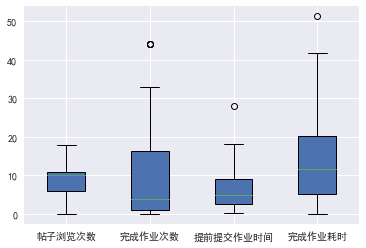

In [9]:
d1_clean = df_clean['帖子浏览次数']
d2_clean = df_clean['完成作业次数']
d3_clean = df_clean['提前提交作业时间']
d4_clean = df_clean['完成作业耗时']

# 横坐标，显示均值
plt.boxplot([d1_clean,d2_clean,d3_clean,d4_clean],patch_artist=True,labels=['帖子浏览次数','完成作业次数','提前提交作业时间','完成作业耗时'])
plt.show()

In [10]:
# 巴特利特球形度检验
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
 
chi_square_value, p_value = calculate_bartlett_sphericity(df_clean)
chi_square_value, p_value

(412.7942009319403, 1.4130121532448357e-78)

In [11]:
# KMO检验
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df_clean)
kmo_model

0.7024890075867246

In [12]:
student_profiles_4 = pd.read_csv('stu_portrait.csv')
student_profiles_1 = pd.read_csv('信息接收维度.csv')

student_profiles = pd.merge(student_profiles_4, student_profiles_1, on='personid', how='outer')

student_profiles.rename(columns={'personid':'学生编号','score_x':'分数','post_views':'帖子浏览次数','job_num':'完成作业次数',
                   'time_before_ddl':'提前提交作业时间','consume_time':'完成作业耗时','receive_time':'信息接收处理时间'},inplace=True)
student_profiles.drop('score_y', axis=1, inplace=True)
student_profiles.dropna(inplace=True)
student_profiles.to_csv('stu_portrait_clean.csv')

In [18]:
# 信息感知、加工、投入维度、学习态度维度使用百分位数筛选维度类型
# 信息接收维度参考三西格玛准则

def analyze_student_profiles(student_profile_file):
    # 读取学生画像表格
    student_profiles = pd.read_csv(student_profile_file)

    # 计算五个维度的阈值
    ddl_threshold = student_profiles["提前提交作业时间"].quantile(0.5)
    post_threshold = student_profiles["帖子浏览次数"].quantile(0.5)
    job_threshold = student_profiles["完成作业次数"].quantile(0.5)
    consume_threshold = student_profiles["完成作业耗时"].quantile(0.5)
    mean_receive = student_profiles['信息接收处理时间'].mean()
    std_receive = student_profiles['信息接收处理时间'].std()
    
    # 计算积极型和拖延型的分界点
    std_times = 1
    boundary_low = mean_receive - std_times * std_receive
    boundary_high = mean_receive + std_times * std_receive
    
    # 定义一个空的结果列表
    results = []

    # 遍历所有学生画像，计算其在五个维度下的类型
    for _, student_profile in student_profiles.iterrows():
        information_processing_type = "沉思型" if student_profile["提前提交作业时间"] > ddl_threshold else "活跃型"
        information_perception_type = "直觉型" if student_profile["帖子浏览次数"] > post_threshold else "感悟型"
        information_input_type = "低投入型" if student_profile["完成作业次数"] > job_threshold else "高投入型"
        learning_attitude_type = "依赖型" if student_profile["完成作业耗时"] > consume_threshold else "独立型"
        info_reception = '拖延型' if  student_profile['信息接收处理时间'] <= boundary_low else '积极型'
        
        # 将结果添加到结果列表中
        result = {
            "学生编号": student_profile["学生编号"],
            "信息加工维度": information_processing_type,
            "信息感知维度": information_perception_type,
            "信息投入维度": information_input_type,
            "学习态度维度": learning_attitude_type,
            "信息接收维度": info_reception,
        }
        results.append(result)

    # 将结果列表转换为DataFrame并返回
    return pd.DataFrame(results)

# 调用函数，传入学生画像文件名
result = analyze_student_profiles("stu_portrait_clean.csv")

# 打印结果
print(result)
result.to_csv('result_portrait.csv')

              学生编号 信息加工维度 信息感知维度 信息投入维度 学习态度维度 信息接收维度
0   111943588.0000    沉思型    直觉型   高投入型    依赖型    积极型
1   111943630.0000    活跃型    直觉型   高投入型    依赖型    积极型
2   111943631.0000    沉思型    直觉型   高投入型    独立型    积极型
3   111943800.0000    活跃型    直觉型   高投入型    依赖型    积极型
4   111943864.0000    活跃型    直觉型   高投入型    依赖型    积极型
..             ...    ...    ...    ...    ...    ...
197 197259586.0000    沉思型    感悟型   低投入型    独立型    积极型
198 197259971.0000    沉思型    感悟型   低投入型    独立型    积极型
199 197261324.0000    沉思型    感悟型   低投入型    依赖型    积极型
200 197261517.0000    沉思型    感悟型   低投入型    依赖型    积极型
201 197263536.0000    沉思型    感悟型   低投入型    独立型    积极型

[202 rows x 6 columns]
